In [23]:
import pandas as pd
import numpy as np
import requests
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import CatBoostEncoder
from sklearn.model_selection import RandomizedSearchCV

In [24]:
df = pd.read_csv("scraped_car_data.csv")

In [25]:
df.head()

,Car Title,Price,Marca,Modelo,Año,Versión,Color,Tipo de combustible,Puertas,Transmisión,...,Con sensor de estacionamiento por cámara trasera,Con sistema de estacionamiento automático,Sistema ISOFIX,Aviso de punto ciego,Inspección vehicular,Largo x Altura,Entrada internacional legalizada,Con impacto positivo,Unnamed: 85,Baúl
0,Fiat FASTBACK 1.3 T270 At6,19.000.000,Fiat,FASTBACK,2024.0,1.3 T270 At6,Plateado,Nafta,5.0,Automática,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fiat Cronos 1.3 Drive Mt,23.300.000,Fiat,Cronos,2024.0,1.3 Drive Mt,Blanco,Nafta,4.0,Manual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fiat Strada 1.4 8v Freedom Cd,6.400,Fiat,Strada,2024.0,1.4 8v Freedom Cd,Negro,Nafta,3.0,Manual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fiat FASTBACK 1.3 Abarth T270 At6,38.000.000,Fiat,FASTBACK,2024.0,1.3 Abarth T270 At6,Gris,Nafta,5.0,Automática,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fiat Toro 1.8 Freedom,18.000.000,Fiat,Toro,2024.0,1.8 Freedom,Blanco,Nafta,4.0,Automática,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1466 entries, 0 to 1465
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Car Title                                           1466 non-null   object 
 1   Price                                               1466 non-null   object 
 2   Marca                                               1462 non-null   object 
 3   Modelo                                              1462 non-null   object 
 4   Año                                                 1462 non-null   float64
 5   Versión                                             1462 non-null   object 
 6   Color                                               1460 non-null   object 
 7   Tipo de combustible                                 1462 non-null   object 
 8   Puertas                                             1462 non-null   float64
 9

In [27]:
print(df.isna().mean())

Car Title                           0.000000
Price                               0.000000
Marca                               0.002729
Modelo                              0.002729
Año                                 0.002729
                                      ...   
Largo x Altura                      0.998636
Entrada internacional legalizada    0.998636
Con impacto positivo                0.997271
Unnamed: 85                         1.000000
Baúl                                0.928377
Length: 87, dtype: float64


In [28]:
# Dropear columnas que tengan mas de 50% de missing values
df = df.loc[:,df.isna().mean() < 0.5]

In [29]:
# Dropear las filas que tengan missing values en precio, marca, modelo o año
columnas = ["Price", "Marca", "Modelo", "Año"]
df.dropna(subset=columnas, inplace=True)

In [30]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

In [31]:
for x in cat_cols:
    print(df[x].value_counts(normalize=True) * 100)

Motor
1.3                       32.692308
1.4                       10.851648
1.0                        9.134615
1.6                        9.065934
INYECCION MULTI PUNTO      8.997253
1.8                        8.653846
2.0                        7.005495
TURBO DIESEL INYECCION     2.129121
2.8                        2.060440
1.5                        1.717033
2.4                        1.648352
1.2                        1.373626
TURBOALIMENTADO            1.304945
3.0                        0.961538
2.3                        0.343407
2.5                        0.274725
3.2                        0.274725
2.2                        0.206044
1.3 turbo                  0.137363
1.0 Turbo                  0.137363
1.0T                       0.068681
1,4 T LTZ PLUS A/T         0.068681
TOMO USADOS                0.068681
FWD PREMIER                0.068681
6.2 HEMI V8 707HP          0.068681
1.6 nafta                  0.068681
1.3T T 270                 0.068681
TURBO DIESEL          

In [32]:
# Cambiar tipo de data de features
df['Kilómetros'] = df['Kilómetros'].str.replace(' km', '').astype(float)
df['Edad auto'] = 2024 - df['Año'].astype(int)
df['Capacidad del tanque'] = df['Capacidad del tanque'].str.replace(' L', '').astype(float)
df['Price'] = df['Price'].str.replace('.', '').astype(float)

In [33]:
# Con potencia tenemos que hacer un paso mas, ya que algunos estan en cv y otros en hp
df.loc[df['Potencia'].str.contains('hp', na=False), 'Potencia'] = (df['Potencia'].str.replace(' hp', '', regex=False).str.strip())

df.loc[df['Potencia'].str.contains('cv', na=False), 'Potencia'] = (df['Potencia'].str.replace(' cv', '', regex=False).str.strip().astype(float) * 1.01387)

df['Potencia'] = df['Potencia'].astype(float)

In [34]:
# Transformar la columna de largo x altura x ancho
df[['Largo', 'Altura', 'Ancho']] = df['Largo x Altura x Ancho'].str.extract(r'(\d+) mm x (\d+) mm x (\d+) mm').astype(float)

In [35]:
# Algunos valores estan en metros
df[['Largo', 'Altura', 'Ancho']] = df[['Largo', 'Altura', 'Ancho']].where(df[['Largo', 'Altura', 'Ancho']] > 100, (df[['Largo', 'Altura', 'Ancho']])*1000 )

In [36]:
# Lo mismo para distancia entre ejes
df['Distancia entre ejes'] = df['Distancia entre ejes'].str.extract(r'(\d+) mm').astype(float)
df['Distancia entre ejes'] = df['Distancia entre ejes'].where(df['Distancia entre ejes'] > 100, (df['Distancia entre ejes'])*1000 )

In [37]:
# Dropeamos features muy desbalanceadas
df.drop(columns=['Computadora de abordo', 'Frenos ABS', 'Tracción ASR', 'Porta vasos', 'Airbag para conductor y pasajero'], inplace=True)


In [38]:
# En motor tenemos la cilindrada y si es turbo. Hago dos features, una sera la cilindrada, y la otra una dummy de turbo
df['Tamaño motor'] = df['Motor'].str.extract(r'([0-9]\.[0-9])').astype(float)
df['Turbo'] = df['Motor'].str.contains('t|T', na=False).astype(int)

In [39]:
# En price tenemos algunos precios que estan en dolares y otros en pesos. Asumiremos que los autos por debajo de 150.000 son en dolares y los convertiremos a pesos al dolar blue
# Scrapear precio de venta del dolar blue

url = "https://mercados.ambito.com//dolar/informal/variacion"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36 OPR/113.0.0.0'}
response = requests.get(url, headers=headers)

dolar = float(response.json()['venta'].replace(',','.'))

In [40]:
# Pasar dolar a pesos
df.loc[df['Price'] < 150000, 'Price'] = df.loc[df['Price'] < 150000, 'Price'] * dolar

In [41]:
# Drop features transformadas o innecesarias
df.drop(columns=['Largo x Altura x Ancho','Año','Car Title','Versión','Motor'], inplace=True)

In [42]:
# Separar features numericas de categoricas
cat_features = df.loc[:,df.dtypes==object].columns
num_features = df.loc[:,df.dtypes!=object].drop('Price', axis=1).columns

In [43]:
# Llenar missing values que quedan
for x in cat_features:
    df[x].fillna(df[x].mode().iloc[0], inplace=True)

for x in num_features:
    df[x].fillna(df[x].median(), inplace=True)

C:\Users\Windows\AppData\Local\Temp\ipykernel_264\1203169913.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[x].fillna(df[x].mode().iloc[0], inplace=True)
C:\Users\Windows\AppData\Local\Temp\ipykernel_264\1203169913.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [44]:
# Definir feature y target
X = df.drop('Price', axis=1)
y = df['Price']

In [45]:
# Separamos en data de entrenamiento y de validacion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [46]:
# Separar features categoricas dependiendo de cardinalidad para mejor procesamiento
alta_card_cat_features = []
baja_card_cat_features = []

for x in cat_features:
    if len(X_train[x].unique()) > 3:
        alta_card_cat_features.append(x)
    else:
        baja_card_cat_features.append(x)


In [47]:
# Escalar features numericas
scaler = StandardScaler()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

In [48]:
# Encodear features de cardinalidad alta
catboost = CatBoostEncoder()

X_train[alta_card_cat_features] = catboost.fit_transform(X_train[alta_card_cat_features], y_train)
X_test[alta_card_cat_features] = catboost.transform(X_test[alta_card_cat_features])

In [49]:
# Encodear features de cardinalidad baja

X_train_dummies = pd.get_dummies(X_train[baja_card_cat_features], prefix=baja_card_cat_features).astype(int)
X_test_dummies = pd.get_dummies(X_test[baja_card_cat_features], prefix=baja_card_cat_features).astype(int)


In [50]:
X_test_dummies

,Transmisión_Automática,Transmisión_Automática secuencial,Transmisión_Manual,AM/FM_No,AM/FM_Sí,Aire acondicionado_No,Aire acondicionado_Sí
1002,1,0,0,0,1,0,1
314,0,0,1,0,1,0,1
518,1,0,0,0,1,0,1
1367,1,0,0,0,1,0,1
537,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...
976,1,0,0,0,1,0,1
560,0,0,1,0,1,0,1
254,1,0,0,0,1,0,1
430,1,0,0,0,1,0,1


In [51]:
X_train = pd.concat([
        X_train.drop(columns=baja_card_cat_features),
        X_train_dummies],
        axis=1)

X_test = pd.concat([
        X_test.drop(columns=baja_card_cat_features),
        X_test_dummies],
        axis=1)

In [52]:
# Lista de parametros para pasar al Randomized Search CV
params = {
    'learning_rate' : [0.03 ,0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth' : [2 ,3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight' : [ 1, 3, 5, 7 ],
    'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4, 3, 5, 10 ],
    'lambda' : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 3, 5, 10 ],
    'n_estimators' : [30, 40, 50, 60 ,80],
    'colsample_bytree' : [0.1, 0.2 ,0.3, 0.4]
}

In [53]:
# Definir el modelo
model = xgb.XGBRegressor(objective = 'reg:squarederror')

In [54]:
# Buscamos los mejores parametros para el modelo
rs_model=RandomizedSearchCV(model,param_distributions=params,n_iter=20,scoring='neg_root_mean_squared_error',cv=3,verbose=3)
rs_model.fit(X_train, y_train)

In [56]:
print(rs_model.best_params_)
print(rs_model.best_score_)
best_params = rs_model.best_params_

{'n_estimators': 30, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.15, 'lambda': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.3}
-7983232.797340796


In [57]:
# Definimos y entrenamos un nuevo modelo con los parametros optimos
model_bp =  xgb.XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse', **best_params, early_stopping_rounds=10)
eval_set = [(X_train, y_train), (X_test, y_test)]

model_bp.fit(X_train, y_train, eval_set=eval_set)

In [59]:
results = model_bp.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

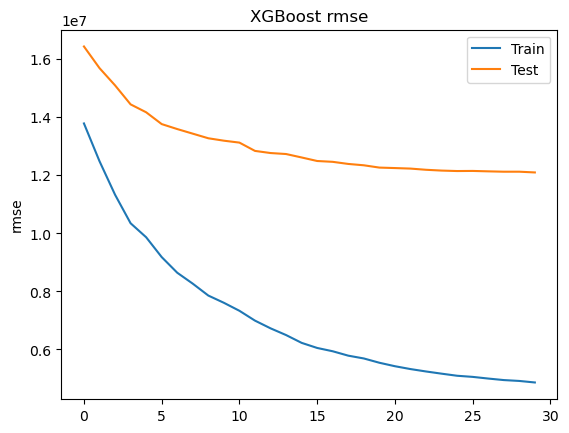

In [60]:
# Plotear metricas del entrenamiento
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

# Se puede observar como el modelo se ajusta demasiado a los datos de entrenamiento y la loss de entrenamiento y testeo no convergen

<Axes: >

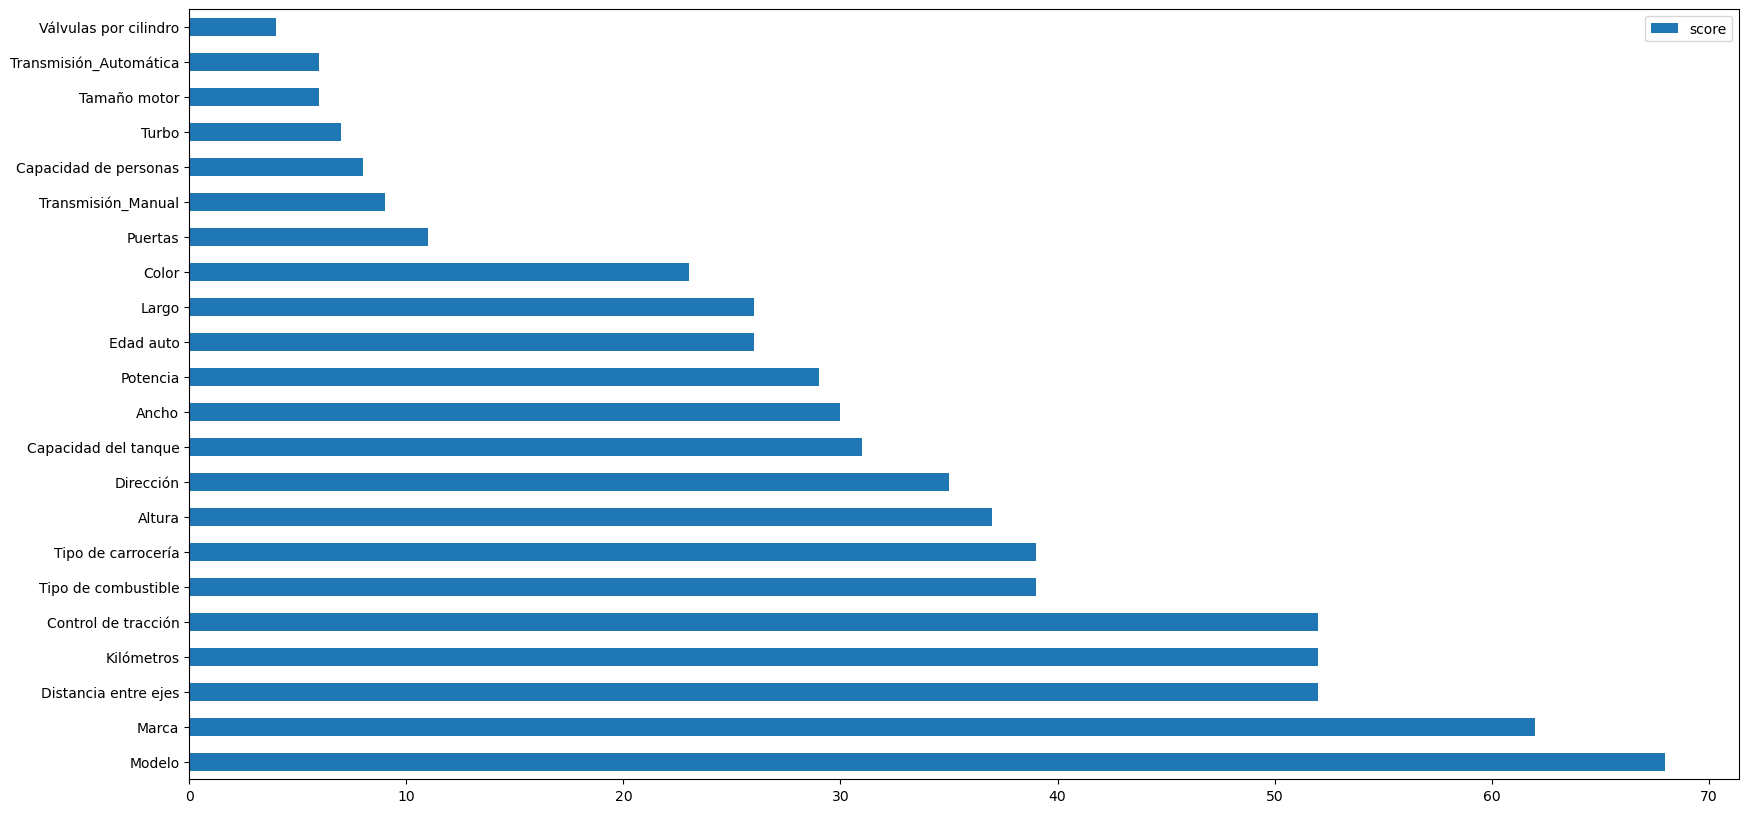

In [64]:
# Primero buscaremos descartar las features menos importantes
feature_important = model_bp.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [66]:
# Descartamos features menos importantes, buscamos nuevos parametros y entrenamos un nuevo modelo
X_train2 =  X_train.drop(columns=['Válvulas por cilindro', 'Transmisión_Automática', 'Tamaño motor', 'Turbo', 'Capacidad de personas', 'Transmisión_Manual', 'Puertas'])
X_test2 =  X_test.drop(columns=['Válvulas por cilindro', 'Transmisión_Automática', 'Tamaño motor', 'Turbo', 'Capacidad de personas', 'Transmisión_Manual', 'Puertas'])
eval_set2 = [(X_train2, y_train), (X_test2, y_test)]

In [70]:
model2 = xgb.XGBRegressor(objective = 'reg:squarederror')
rs_model2=RandomizedSearchCV(model2,param_distributions=params,n_iter=20,scoring='neg_root_mean_squared_error',cv=3,verbose=3)
rs_model2.fit(X_train2, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END colsample_bytree=0.1, gamma=0.0, lambda=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=40;, score=-11648756.277 total time=   0.1s
[CV 2/3] END colsample_bytree=0.1, gamma=0.0, lambda=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=40;, score=-10753160.445 total time=   0.1s
[CV 3/3] END colsample_bytree=0.1, gamma=0.0, lambda=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=40;, score=-7810205.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.1, gamma=3, lambda=5, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=30;, score=-13178631.033 total time=   0.0s
[CV 2/3] END colsample_bytree=0.1, gamma=3, lambda=5, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=30;, score=-11447994.238 total time=   0.0s
[CV 3/3] END colsample_bytree=0.1, gamma=3, lambda=5, learning_rate=0.05, max_depth=15, min_child_weigh

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=None, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.1, 0.2, 0.3,
                                                             0.4],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 3, 5,
                                                  10],
                                        'lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                   3, 5, 10],
                                        'learning_rate': [0.03, 0.05, 0.1, 0.15,
                                                          0.2, 0.25, 0.3],
                                        'max_depth': [2, 3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [30, 40, 50, 60, 80]},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [71]:
print(rs_model2.best_params_)
print(rs_model2.best_score_)
best_params2 = rs_model2.best_params_

{'n_estimators': 60, 'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.15, 'lambda': 0.5, 'gamma': 5, 'colsample_bytree': 0.3}
-7965176.326738418


In [73]:
model_bp2 =  xgb.XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse', **best_params2, early_stopping_rounds=10)
model_bp2.fit(X_train2, y_train, eval_set=eval_set2)

[0]	validation_0-rmse:13933532.82288	validation_1-rmse:16330207.00237
[1]	validation_0-rmse:12830937.63497	validation_1-rmse:15612314.99014
[2]	validation_0-rmse:11766021.10903	validation_1-rmse:15006723.60266
[3]	validation_0-rmse:11124536.28150	validation_1-rmse:14670496.31084
[4]	validation_0-rmse:10432124.26313	validation_1-rmse:14248954.94894
[5]	validation_0-rmse:10006111.97197	validation_1-rmse:13998477.60088
[6]	validation_0-rmse:9432298.75405	validation_1-rmse:13725931.31416
[7]	validation_0-rmse:9215850.22034	validation_1-rmse:13592470.67479
[8]	validation_0-rmse:8787642.87750	validation_1-rmse:13413133.27590
[9]	validation_0-rmse:8624987.40987	validation_1-rmse:13341978.82315
[10]	validation_0-rmse:8320009.72530	validation_1-rmse:13141480.93270
[11]	validation_0-rmse:7987883.04779	validation_1-rmse:12949900.48234
[12]	validation_0-rmse:7850071.99598	validation_1-rmse:12860822.79621
[13]	validation_0-rmse:7555741.18488	validation_1-rmse:12772531.37582
[14]	validation_0-rmse:7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.5, learning_rate=0.15,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, ...)

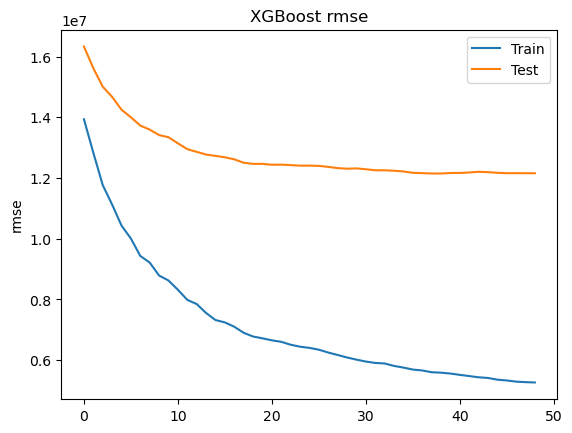

In [74]:
results = model_bp2.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()

In [ ]:
# No se pudo mejorar la performance del modelo, se necesitara aumentarar la cantidad de datos para poder solucionar el overfitting del modelo